# Independent Component Analysis on French Market Data

Students:
- **Name**: Luca Barriviera

- **Name**: Carl-Emil Krarup Jensen

**Project Overview:**  
In this project, we apply the approach from Back et al. (1997), *A First Application of Independent Component Analysis to Extracting Structure from Stock Returns*, to French market data (2001–2010).  

We aim to:  
- Impute missing data using regression-based methods.  
- Check stationarity and non‑Gaussianity of log returns.  
- Decompose the returns using the JADE algorithm for ICA and compare with PCA.  
- Reconstruct the CAC40 index from the dominant components (after thresholding) and compare with the real CAC40 price.

**Notes:**  
- We work with log returns so that price reconstruction is done using an exponential of the cumulative sum.  
- Missing data in selected stocks is imputed by a linear regression model.
- We restrict some analyses to data after 23 July 2008 so that imputation does not affect reconstruction.

---

*Below is the complete code.*

## 1. Imports and Data Loading

We start by importing the necessary libraries and loading the data.
We then check which stocks have missing data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from numpy.linalg import pinv
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

import warnings
from jadeR import jadeR

# Suppress KPSS interpolation warnings
warnings.simplefilter("ignore", InterpolationWarning)

# Load data from Excel file.
file_path = 'cac40.xls'
df = pd.read_excel(file_path, sheet_name='Données quotidiennes', usecols="A:AP")
weights = pd.read_excel(file_path, sheet_name='Poids')["Poids dans l'indice"]

# Convert 'Date' column to datetime and set as index.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Save the CAC40 column separately and remove it from df.
cac40 = df['CAC 40'].copy()
df.drop(columns=['CAC 40'], inplace=True)

# Save a copy of the original (pre-imputation) data.
df_orig = df.copy()

print("Missing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values per column:
Credit Agricole SA        247
Electricite de France    1273
Gaz de France SA         1177
Suez SA                  1970
dtype: int64


## 2. Regression Imputation for Missing Data

In our dataset, the stocks Credit Agricole SA, Electricite de France, Gaz de France SA, and Suez SA contain missing values. 
To address these gaps, we apply regression-based imputation with the following:

**Linear Regression for the Target Column**  
   - For rows where the target column is observed, we train a LinearRegression model using the mean-imputed predictor data.  
   - For rows where the target column is missing, we use the fitted model to predict and fill in the missing target values.

We choose a linear model for interpretability and ease of implementation. However, more advanced methods e.g., XGBoost or Neural Networks could capture data patterns more effectively and yield more accurate predictions.

After completing the imputation, we visualize the results by plotting both the imputed values and the original stock prices alongside the CAC40 index.

In [2]:
def regression_impute_column(df, target_col):
    """
    Impute missing values in target_col using LinearRegression on the remaining columns.
    """
    predictors = df.columns.drop(target_col)
    train_idx = df[target_col].notnull()
    if train_idx.sum() == 0:
        print(f"No observed data for {target_col}; skipping imputation.")
        return df[target_col]
    X_train = df.loc[train_idx, predictors].values
    y_train = df.loc[train_idx, target_col].values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    missing_idx = df[target_col].isnull()
    if missing_idx.sum() > 0:
        X_missing = df.loc[missing_idx, predictors].values
        X_missing = imputer.transform(X_missing)
        predicted_values = reg.predict(X_missing)
        df.loc[missing_idx, target_col] = predicted_values
    else:
        print(f"No missing data in {target_col}; skipping regression imputation.")
    return df[target_col]

# Identify columns with missing values and impute.
cols_with_missing = df.columns[df.isnull().sum() > 0].tolist()
print("Columns with missing values:", cols_with_missing)
for col in cols_with_missing:
    print(f"Imputing missing values for {col}...")
    regression_impute_column(df, col)

Columns with missing values: ['Credit Agricole SA', 'Electricite de France', 'Gaz de France SA', 'Suez SA']
Imputing missing values for Credit Agricole SA...
Imputing missing values for Electricite de France...
Imputing missing values for Gaz de France SA...
Imputing missing values for Suez SA...


## 3. Visualize Imputed vs. Observed Data

For each imputed column, we automatically determine the cutoff date (the first valid date in the original data) and plot the imputed values (before cutoff, in red) versus the observed values (from cutoff onward, in blue). The CAC40 series is overlaid (in green) using a secondary axis.

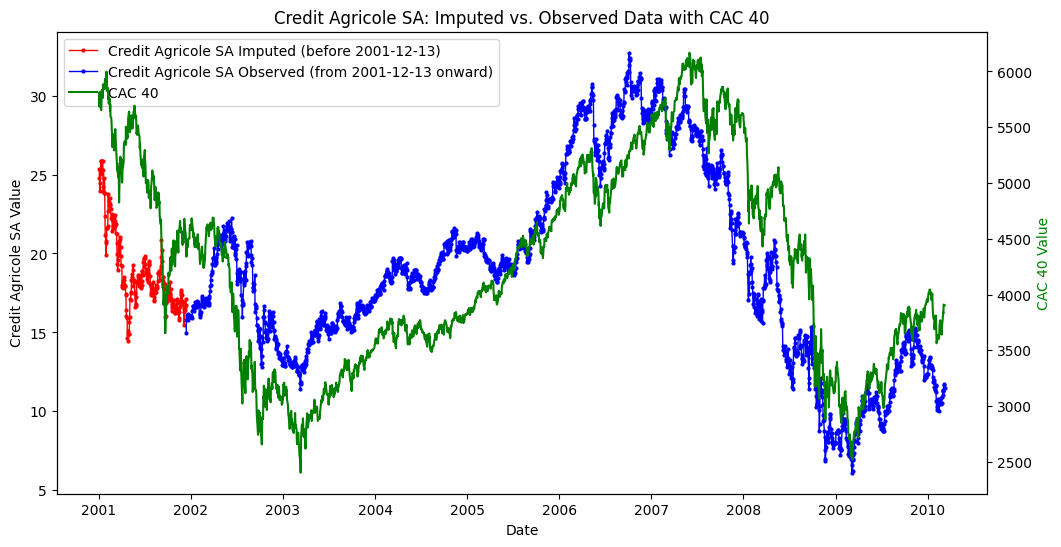

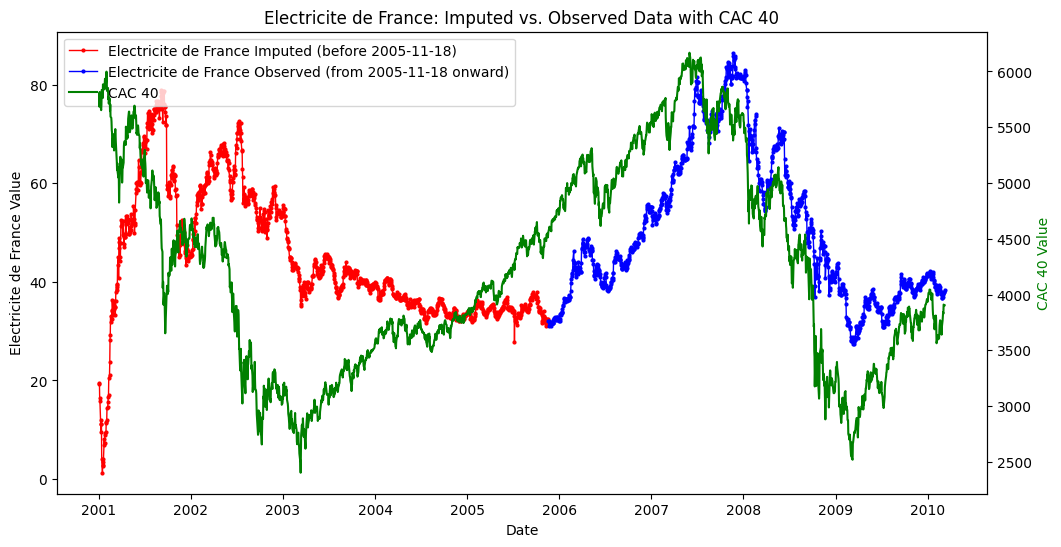

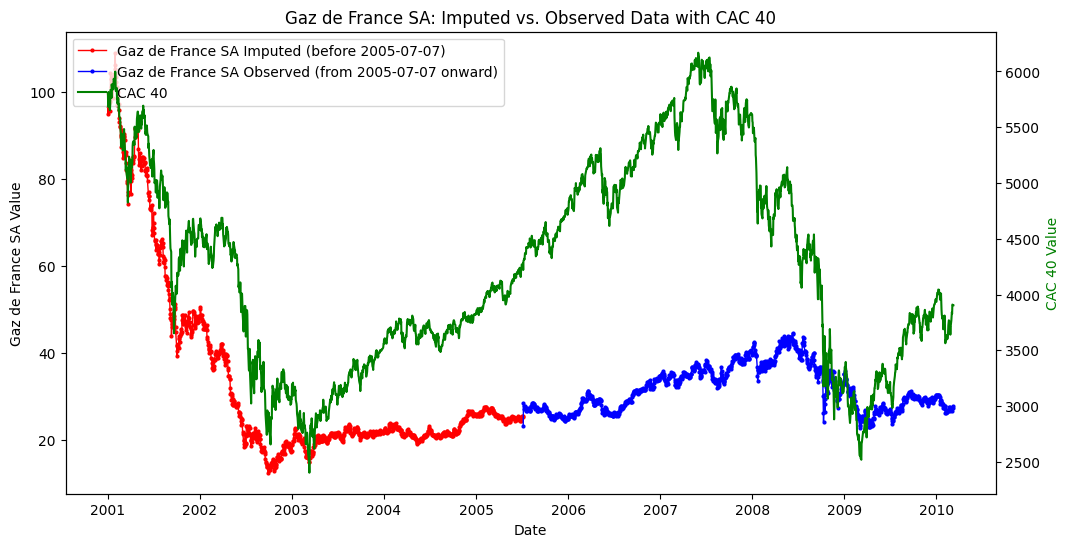

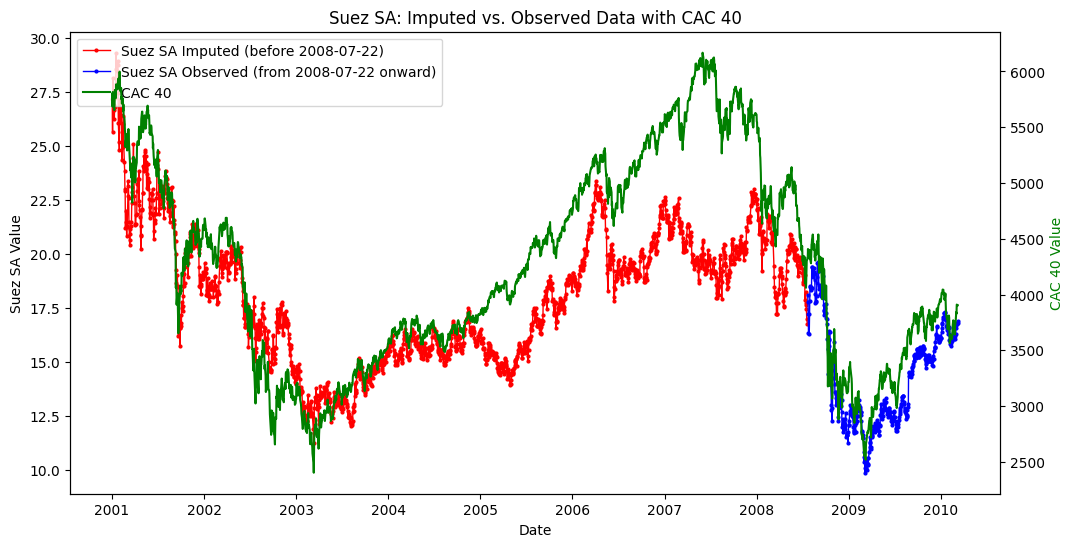

In [3]:
for col in cols_with_missing:
    series = df[col]
    cutoff = df_orig[col].first_valid_index()
    if cutoff is None:
        continue
    imputed_part = series.loc[series.index < cutoff]
    observed_part = series.loc[series.index >= cutoff]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(imputed_part.index, imputed_part,
             label=f'{col} Imputed (before {cutoff.date()})',
             color='red', marker='o', markersize=2, linewidth=1)
    ax1.plot(observed_part.index, observed_part,
             label=f'{col} Observed (from {cutoff.date()} onward)',
             color='blue', marker='o', markersize=2, linewidth=1)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(f"{col} Value", color='black')
    ax2 = ax1.twinx()
    ax2.plot(df.index, cac40,
             label="CAC 40", color='green', linestyle='-', linewidth=1.5)
    ax2.set_ylabel("CAC 40 Value", color='green')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.title(f"{col}: Imputed vs. Observed Data with CAC 40")
    plt.show()

## 4. Stationarity and Non-Gaussianity Checks

Before applying ICA to our datasets, we must verify that the observed signals $x(t)$ satisfy the stationarity and non‑Gaussianity assumptions required by many ICA algorithms. In particular, ICA methods typically perform best when the input time series do not exhibit strong time-dependent trends or variances. 

To assess stationarity, we use two well‑established statistical tests:

1. **Augmented Dickey-Fuller (ADF) Test**  
   The ADF test checks the null hypothesis that a time series has a unit root, i.e. that it is non-stationary. A sufficiently low p-value (for example, below 0.01) allows us to reject the null hypothesis, suggesting that the series is stationary.

2. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**  
   In contrast, the KPSS test examines the null hypothesis that the time series is stationary. A high p-value (for example, above 0.09) indicates that we fail to reject the hypothesis of stationarity.

Because each test uses an opposing null hypothesis, applying both methods provides complementary perspectives on the data’s stationarity. Using both tests is advantageous: if both tests indicate stationarity (i.e., ADF p-value is low and KPSS p-value is high), we gain stronger confidence that the series exhibit stable statistical properties over time. This is crucial because ICA’s effectiveness relies on having time series with constant statistical properties.

For our analysis, we compute log returns $\Delta x_t$ by taking the first difference of the log of the stock prices (as described in Back et al. 1997, section 3.2). We then apply both the ADF and KPSS tests to each stock’s return series. The logic is as follows:
- If the ADF p-value is below our chosen threshold (e.g., 0.01), we classify the series as stationary according to the ADF test.
- If the KPSS p-value is above a threshold (e.g., 0.09), we classify the series as stationary according to the KPSS test.

By comparing the number of stocks that pass these criteria, we ensure that our return series are free from strong non-stationary behavior, thus justifying the subsequent use of ICA to extract the underlying independent factors. This dual-testing approach helps build a robust foundation for our ICA analysis.

Hereafter we do QQ plots for the signals to check if their distribution satisfies the criteria of non-Gaussianity.

                                      ADF p-value  KPSS p-value
Accor SA                             0.000000e+00      0.100000
Air Liquide                          2.560427e-30      0.100000
Alcatel-Lucent                       1.033916e-14      0.100000
Alstom                               0.000000e+00      0.081336
Arcelor Mittal                       0.000000e+00      0.100000
AXA SA                               5.244919e-23      0.100000
BNP Paribas                          4.086402e-13      0.100000
Bouygues                             8.147395e-19      0.100000
Cap Gemini SA                        0.000000e+00      0.100000
Carrefour SA                         0.000000e+00      0.100000
Credit Agricole SA                   8.448449e-16      0.100000
Groupe Danone                        4.041842e-30      0.100000
Dexia SA                             2.010107e-13      0.100000
EADS                                 4.157709e-29      0.100000
Electricite de France                4.4

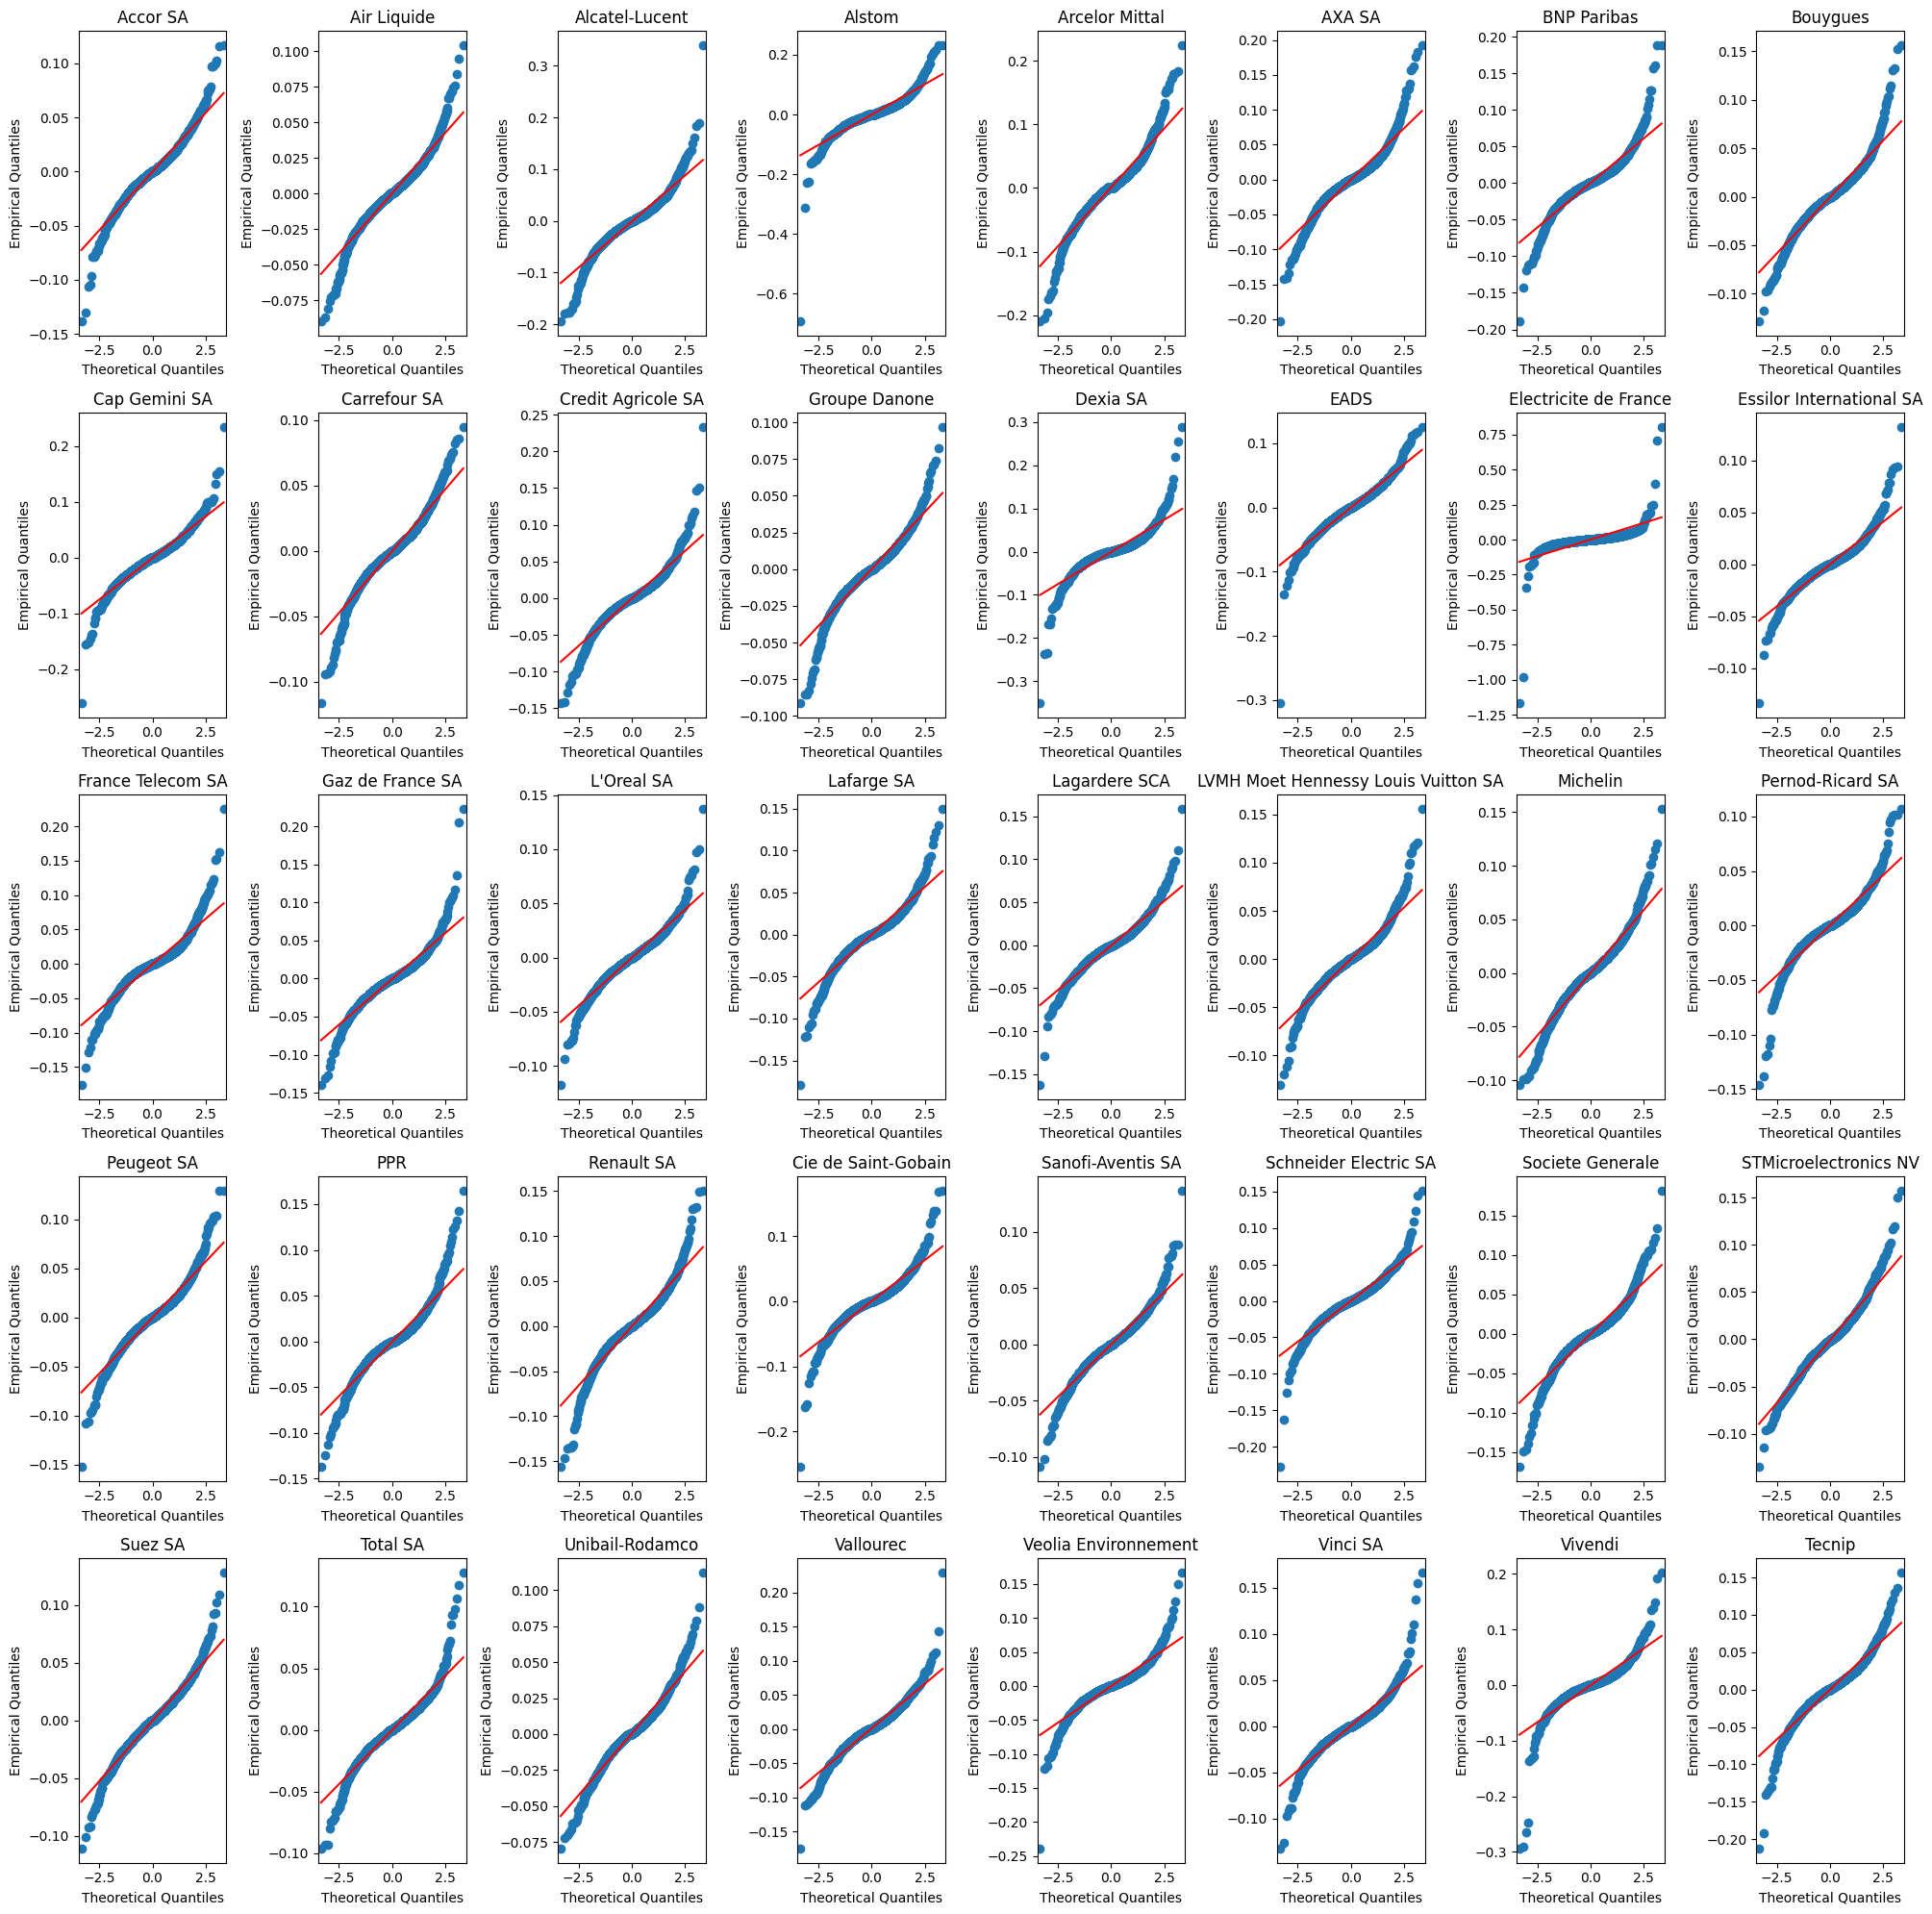

In [4]:
# Compute log returns.
df_returns = np.log(df).diff().dropna()

# Run ADF and KPSS tests.
results = {}
for col in df_returns.columns:
    data = df_returns[col].dropna()
    adf_result = adfuller(data)
    adf_p = adf_result[1]
    try:
        kpss_result = kpss(data, regression='c', nlags="auto")
        kpss_p = kpss_result[1]
    except Exception:
        kpss_p = np.nan
    results[col] = {"ADF p-value": adf_p, "KPSS p-value": kpss_p}
results_df = pd.DataFrame(results).T
print(results_df)

# Define thresholds.
adf_thresh = 0.01
kpss_thresh = 0.09
stocks_adf_stationary = results_df.index[results_df["ADF p-value"] < adf_thresh].tolist()
stocks_kpss_stationary = results_df.index[results_df["KPSS p-value"] > kpss_thresh].tolist()
print("Summary of Stationarity Tests on Log Returns")
print("--------------------------------------------------")
print(f"Total number of stocks: {len(results_df)}")
print(f"Stocks with ADF p-value < {adf_thresh}: {len(stocks_adf_stationary)}: " + ", ".join(stocks_adf_stationary))
print(f"Stocks with KPSS p-value > {kpss_thresh}: {len(stocks_kpss_stationary)}: " + ", ".join(stocks_kpss_stationary))
print("--------------------------------------------------")

# Create a grid of Q-Q plots for all stocks.
n_stocks = len(df_returns.columns)
ncols = 8
nrows = math.ceil(n_stocks / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4*nrows))
axes = axes.flatten()
for i, col in enumerate(df_returns.columns):
    data = df_returns[col].dropna()
    sm.qqplot(data, line='s', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("Theoretical Quantiles")
    axes[i].set_ylabel("Empirical Quantiles")
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

These results indicate that almost all of our stocks are stationary. Specifically, the KPSS test suggests that 38 stocks do not reject the null hypothesis of stationarity (p-value > 0.09), while the ADF test, which tests for the presence of a unit root, strongly rejects non-stationarity for all 40 stocks (p-value < 0.01). Moreover, an analysis of the QQ-plots reveals that the signals exhibit heavy tails, indicating deviations from normality. This observation supports the conclusion that the signals satisfy the criterion for non-Gaussianity. Overall, these complementary tests provide confidence that the majority of our return series are stationary and exhibit non-gaussianity justifying the subsequent use of ICA and PCA for further analysis.

## 5. Independent Component Analysis (ICA) via JADE

We now perform ICA on the log returns using the JADE algorithm.  
The JADE function expects a data matrix of shape (d, T) (where d is the number of stocks and T is the number of time samples).
We then build a DataFrame of independent components (`df_ICs`).

In [5]:
W = jadeR(df_returns.values.T, verbose=True)
ICs = W @ (df_returns.values.T)
print("ICA output shape:", ICs.shape)
df_ICs = pd.DataFrame(ICs.T, columns=[f"IC{i}" for i in range(1, 41)])
df_ICs.index = df_returns.index

jade -> Looking for 40 sources
jade -> Removing the mean value
jade -> Whitening the data
jade -> Estimating cumulant matrices
jade -> Contrast optimization by joint diagonalization
jade -> Sweep #  0
completed in 780 rotations
jade -> Sweep #  1
completed in 780 rotations
jade -> Sweep #  2
completed in 780 rotations
jade -> Sweep #  3
completed in 780 rotations
jade -> Sweep #  4
completed in 780 rotations
jade -> Sweep #  5
completed in 780 rotations
jade -> Sweep #  6
completed in 778 rotations
jade -> Sweep #  7
completed in 780 rotations
jade -> Sweep #  8
completed in 780 rotations
jade -> Sweep #  9
completed in 779 rotations
jade -> Sweep # 10
completed in 778 rotations
jade -> Sweep # 11
completed in 779 rotations
jade -> Sweep # 12
completed in 775 rotations
jade -> Sweep # 13
completed in 776 rotations
jade -> Sweep # 14
completed in 775 rotations
jade -> Sweep # 15
completed in 776 rotations
jade -> Sweep # 16
completed in 780 rotations
jade -> Sweep # 17
completed in 776 

## 6. Plot Top 5 Dominant ICA Components

We compute the L∞ norm (max absolute value) for each independent component and select the top 5.
We then center these components (subtracting their means) and plot them with vertical offsets.
We also add vertical dotted lines for key financial events.

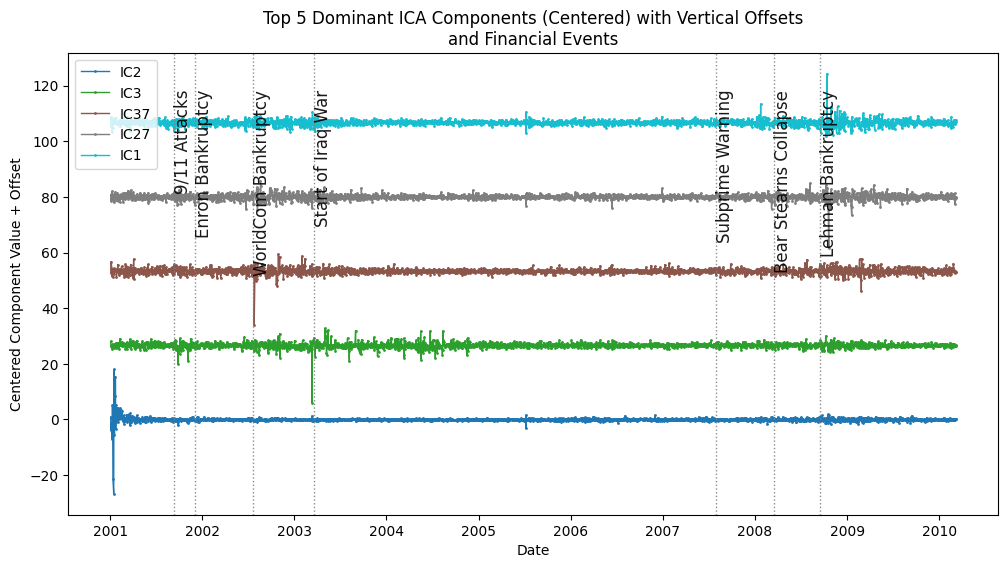

In [6]:
dominance = df_ICs.abs().max()  # L∞ norm for each IC (per column)
dominant_ICs = dominance.sort_values(ascending=False).index[:5]
ICs_centered = df_ICs[dominant_ICs] - df_ICs[dominant_ICs].mean()
offset_value = ICs_centered.abs().max().max()

events = {
    pd.to_datetime("2001-09-11"): "9/11 Attacks",
    pd.to_datetime("2001-12-02"): "Enron Bankruptcy",
    pd.to_datetime("2002-07-21"): "WorldCom Bankruptcy",
    pd.to_datetime("2003-03-20"): "Start of Iraq War",
    pd.to_datetime("2007-08-01"): "Subprime Warning",
    pd.to_datetime("2008-03-16"): "Bear Stearns Collapse",
    pd.to_datetime("2008-09-15"): "Lehman Bankruptcy",
}

plt.figure(figsize=(12, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 5))
for i, comp in enumerate(dominant_ICs):
    plt.plot(df_ICs.index, ICs_centered[comp] + i * offset_value,
             label=comp, marker='o', markersize=1, linewidth=1, color=colors[i])
ax = plt.gca()
for event_date, label in events.items():
    ax.axvline(x=event_date, color="gray", linestyle=":", linewidth=1, alpha=0.9)
    ax.text(event_date, ax.get_ylim()[1]*0.9, label, rotation=90,
            verticalalignment="top", fontsize=12, color="black", alpha=0.9)
plt.title("Top 5 Dominant ICA Components (Centered) with Vertical Offsets\nand Financial Events")
plt.xlabel("Date")
plt.ylabel("Centered Component Value + Offset")
plt.legend(loc="upper left")
plt.show()

## 7. Reconstruction of CAC40 Price using ICA and PCA with Thresholding

We now compare the reconstruction of the CAC40 index using both ICA and PCA.
For both methods, we first restrict our analysis to data on/after **July 23, 2008** (to avoid imputed data).
We then apply an element‑wise threshold to the components so that only values with an absolute magnitude greater than a threshold are retained.
Finally, we use the top *n* dominant components to reconstruct the index price from the log returns.

*Note:* For log returns, the reconstructed price is computed as:

$
\text{price}_t = \text{initial\_price} \times \exp\left(\sum_{i=1}^{t} \text{log return}_i\right)
$

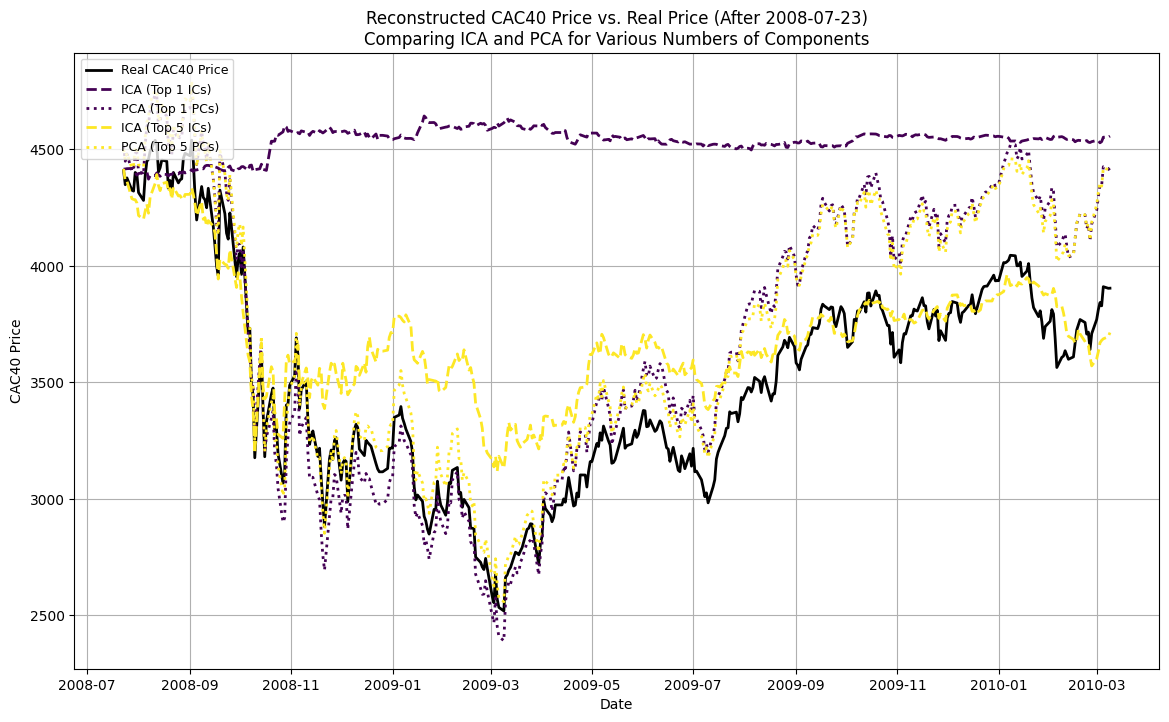

In [ ]:
# Restrict data to dates after the cutoff
cutoff_date = pd.to_datetime("2008-07-23")
df_returns_cut = df_returns.loc[cutoff_date:]
cac40_cut = cac40.loc[cutoff_date:]
initial_cac40 = cac40_cut.iloc[0]


# Normalize weights.
weights_arr = np.array(weights, dtype=float)
weights_arr = weights_arr / weights_arr.sum()

### ICA Reconstruction with Thresholding ###
A_array = np.array(pinv(W))         # Mixing matrix from JADE.
ICs_array = np.array(ICs)             # ICA outputs, shape: (40, T_full)
mask = df_returns.index >= cutoff_date
ICs_cut = ICs_array[:, mask]          # Restricted ICA components.

# Restrict the ICA results to the cutoff period.
mask = df_returns.index >= cutoff_date
ICs_cut = ICs_array[:, mask]    # shape: (40, T_cut)

# Compute dominance (L∞ norm) on the cutoff period.
ica_dominance_cut = np.max(np.abs(ICs_cut), axis=1)
ica_order = np.argsort(ica_dominance_cut)[::-1]  # descending order

# Define a list of numbers of components to test.
n_list = [1, 5]
ica_reconstructions = {}
for n in n_list:
    # Use the top n dominant ICA components.
    top_n_indices = ica_order[:n]
    rec_stock_returns = A_array[:, top_n_indices] @ ICs_cut[top_n_indices, :]  # shape: (40, T_cut)
    rec_index_returns = rec_stock_returns.T @ weights_arr  # shape: (T_cut,)
    rec_price = initial_cac40 * np.exp(np.cumsum(rec_index_returns))
    ica_reconstructions[n] = rec_price

# PCA Reconstruction on the cutoff period
pca = PCA(n_components=df_returns_cut.shape[1])
scores = pca.fit_transform(df_returns_cut.values)  # shape: (T_cut, 40)
loadings = pca.components_                           # shape: (40, 40)
pca_reconstructions = {}
for n in n_list:
    scores_top = scores[:, :n]         # shape: (T_cut, n)
    loadings_top = loadings[:n, :]       # shape: (n, 40)
    # Reconstruct returns from the top n PCs.
    rec_returns = scores_top @ loadings_top   # shape: (T_cut, 40)
    rec_index_returns = rec_returns @ weights_arr  # shape: (T_cut,)
    rec_price = initial_cac40 * np.exp(np.cumsum(rec_index_returns))
    pca_reconstructions[n] = rec_price

# Plot Comparison of Real, ICA and PCA Reconstructions
plt.figure(figsize=(14, 8))
plt.plot(cac40_cut.index, cac40_cut, label="Real CAC40 Price", color="black", linewidth=2)
# For each n, plot both ICA and PCA reconstructions using matching colors.
colors = plt.cm.viridis(np.linspace(0, 1, len(n_list)))
for i, n in enumerate(n_list):
    plt.plot(df_returns_cut.index, ica_reconstructions[n],
             label=f"ICA (Top {n} ICs)", linestyle="--", linewidth=2, color=colors[i])
    plt.plot(df_returns_cut.index, pca_reconstructions[n],
             label=f"PCA (Top {n} PCs)", linestyle=":", linewidth=2, color=colors[i])
plt.title("Reconstructed CAC40 Price vs. Real Price (After 2008-07-23)\nComparing ICA and PCA for Various Numbers of Components")
plt.xlabel("Date")
plt.ylabel("CAC40 Price")
plt.legend(loc="upper left", fontsize=9)
plt.grid(True)
plt.show()

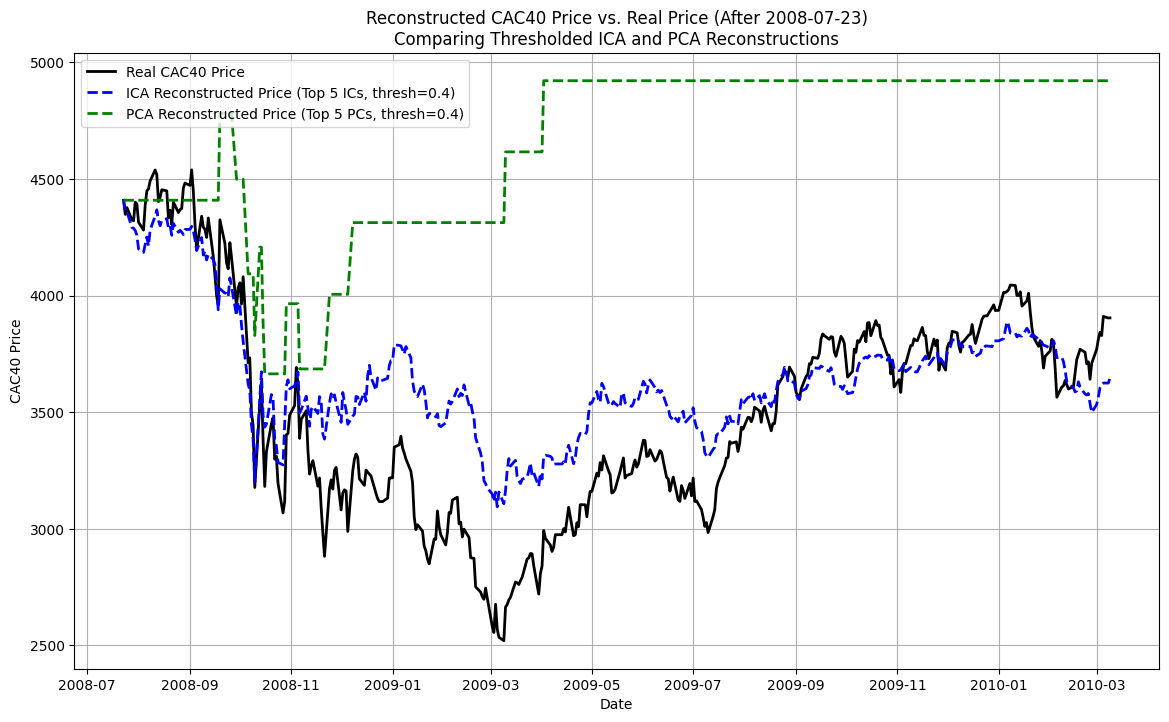

In [ ]:
# Parameters for reconstruction
n_components = 5         # Number of dominant components to use.
threshold_value = 0.4      # Only keep values with |x| >= threshold_value.

# Apply thresholding elementwise
ICs_thresholded = np.where(np.abs(ICs_cut) >= threshold_value, ICs_cut, 0)

# Compute dominance on thresholded ICA components
ica_dominance = np.max(np.abs(ICs_thresholded), axis=1)
ica_order = np.argsort(ica_dominance)[::-1]
top_ica_indices = ica_order[:n_components]

# Reconstruct each stock's returns using only the top n ICA components
reconstructed_stock_returns_ICA = A_array[:, top_ica_indices] @ ICs_thresholded[top_ica_indices, :]
reconstructed_index_returns_ICA = reconstructed_stock_returns_ICA.T @ weights_arr
reconstructed_price_ICA = initial_cac40 * np.exp(np.cumsum(reconstructed_index_returns_ICA))

# PCA Reconstruction with Thresholding
X_cut = df_returns_cut.values      # Log returns (T_cut, 40)
pca = PCA(n_components=X_cut.shape[1])
scores = pca.fit_transform(X_cut)     # (T_cut, 40)
loadings = pca.components_              # (40, 40)

# Apply thresholding to PCA scores elementwise
scores_thresholded = np.where(np.abs(scores) >= threshold_value, scores, 0)
pc_dominance = np.max(np.abs(scores_thresholded), axis=0)
pc_order = np.argsort(pc_dominance)[::-1]
top_pca_indices = pc_order[:n_components]

scores_top = scores_thresholded[:, top_pca_indices]
loadings_top = loadings[top_pca_indices, :]
reconstructed_returns_pca = scores_top @ loadings_top  # (T_cut, 40)
reconstructed_index_returns_pca = reconstructed_returns_pca @ weights_arr
reconstructed_price_pca = initial_cac40 * np.exp(np.cumsum(reconstructed_index_returns_pca))

# Plot Comparison of Real, ICA, and PCA Reconstructions
plt.figure(figsize=(14, 8))
plt.plot(cac40_cut.index, cac40_cut, label="Real CAC40 Price", color="black", linewidth=2)
plt.plot(df_returns_cut.index, reconstructed_price_ICA,
         label=f"ICA Reconstructed Price (Top {n_components} ICs, thresh={threshold_value})",
         color="blue", linestyle="--", linewidth=2)
plt.plot(df_returns_cut.index, reconstructed_price_pca,
         label=f"PCA Reconstructed Price (Top {n_components} PCs, thresh={threshold_value})",
         color="green", linestyle="--", linewidth=2)
plt.title("Reconstructed CAC40 Price vs. Real Price (After 2008-07-23)\nComparing Thresholded ICA and PCA Reconstructions")
plt.xlabel("Date")
plt.ylabel("CAC40 Price")
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.show()

## Discussion
Our implementation largely adheres to the methodology described in "A First Application of Independent Component Analysis to Extracting Structure from Stock Returns," with a few notable deviations. First, due to missing data, we opted to use a linear model for imputation—a departure from the paper’s approach. As earlier mentioned alternative methods, such as neural networks, XGBoost, or random forests, might offer improved performance over a simple linear model.

Additionally, our examination of stationarity revealed that 2 stocks failed the KPSS test, suggesting that further normalization may be necessary for obtaining better ICA results. Non-Gaussianity was primarily assessed through QQ-plots, which provided a clear visual representation of deviations from Gaussian behavior. However, employing more rigorous statistical tests like the Kolmogorov-Smirnov test could further substantiate these findings. Importantly, the two stocks that failed the KPSS test passed the ADF test, indicating stationarity and, therefore, are not expected to introduce excessive noise into our overall results.

Lastly the methodology could be further extended by applying other ICA algorithms (FASTICA, SAS PROC ICA, etc.) for comparison to better assess the robustness of the results.

**Observations:**
- The reconstruction using ICA (via the JADE algorithm) versus PCA can differ, particularly when a threshold is applied to remove minor fluctuations. 
- Adjusting the number of components used (n_components) and the threshold value allows us to examine how much of the signal is captured by the dominant factors.
- In our experiments on log returns (where price is reconstructed via the exponential of cumulative returns), the ICA method tends to capture infrequent large shocks better than PCA.

**Conclusion:**
This notebook demonstrates that after regression‐imputation and proper preprocessing (stationarity and non‑Gaussianity checks), ICA can be effectively used to reconstruct a market index (CAC40) and capture important market events. Comparisons with PCA highlight differences in the decomposition that may be relevant for risk management and asset allocation strategies.